In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('train_data.txt', sep=':::', header=None, names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'], engine = 'python', index_col = 'ID')
test_data = pd.read_csv('test_data.txt', sep=':::', header=None, names=['ID', 'TITLE', 'DESCRIPTION'], engine = 'python', index_col = 'ID')
test_data_sol = pd.read_csv('test_data_solution.txt', sep=':::', header=None, names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'], engine = 'python', index_col = 'ID')

In [3]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train_data['GENRE'])
y_train = encoder.fit_transform(train_data['GENRE'])
y_test = encoder.fit_transform(test_data_sol['GENRE'])

In [4]:
print(y_train)
print(y_test)

[ 8 24  1 ...  7  5 12]
[24  5  7 ...  1  8  8]


In [5]:
train_data.drop('TITLE', axis = 1, inplace = True)
test_data.drop('TITLE', axis = 1, inplace = True)
print(train_data.head())
print(test_data.head())

         GENRE                                        DESCRIPTION
ID                                                               
1       drama    Listening in to a conversation between his do...
2    thriller    A brother and sister with a past incestuous r...
3       adult    As the bus empties the students for their fie...
4       drama    To help their unemployed father make ends mee...
5       drama    The film's title refers not only to the un-re...
                                          DESCRIPTION
ID                                                   
1    L.R. Brane loves his life - his car, his apar...
2    Spain, March 1964: Quico is a very naughty ch...
3    One year in the life of Albin and his family ...
4    His father has died, he hasn't spoken with hi...
5    Before he was known internationally as a mart...


In [6]:
# Cleaning Description
import re
import string
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['one', 'two', 'go','goes', 'get', 'also', 'however', 'tells'] 
stopwords_list += [str(i) for i in range(10)]

nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's|\'s|\'ve|can\'t|n\'t|\'re|\'d|\'ll|\'scuse", lambda match: {
        "what's": "what is",
        "'s": " ",
        "'ve": " have",
        "can't": "cannot",
        "n't": " not",
        "'re": " are",
        "'d": " would",
        "'ll": " will",
        "'scuse": " excuse"
    }[match.group()], text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords_list]
    lemmatized_text = ' '.join([token.lemma_ for token in nlp(' '.join(tokens))])
    
    return lemmatized_text

In [7]:
train_data['DESCRIPTION'] = train_data['DESCRIPTION'].map(lambda x : clean_text(x))5
print(train_data.head())

         GENRE                                        DESCRIPTION
ID                                                               
1       drama   listen conversation doctor parent 10 - year - ...
2    thriller   brother sister past incestuous relationship cu...
3       adult   bus empty student field trip museum natural hi...
4       drama   help unemployed father make end meet edith twi...
5       drama   film title refer un - recover body grind zero ...


In [8]:
test_data['DESCRIPTION'] = test_data['DESCRIPTION'].map(lambda x : clean_text(x))
print(test_data.head())

                                          DESCRIPTION
ID                                                   
1   l.r brane love life car apartment job especial...
2   spain march 1964 quico naughty child three bel...
3   year life albin family shepherd north transylv...
4   father die speak brother 10 year serious cance...
5   know internationally martial art superstar bru...


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 5000)
X_train = vectorizer.fit_transform(train_data['DESCRIPTION'])
X_test = vectorizer.transform(test_data['DESCRIPTION'])

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def calculate_metrics(true_labels, predicted_labels, n_classes):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1_score_val = f1_score(true_labels, predicted_labels, average='weighted')
    confusion_matrix_val = confusion_matrix(true_labels, predicted_labels)
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score_val)
    print("Confusion Matrix:")
    print(confusion_matrix_val)
    
    # Binarize the true labels and predicted labels for ROC curve
    true_labels_bin = label_binarize(true_labels, classes=list(range(n_classes)))
    predicted_labels_bin = label_binarize(predicted_labels, classes=list(range(n_classes)))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_labels_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_bin.ravel(), predicted_labels_bin.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve for each class and micro-average ROC curve
    plt.figure()
    colors = sns.color_palette("hsv", n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2, linestyle='--', label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

Accuracy: 0.52
Precision: 0.5090448658824094
Recall: 0.52
F1 Score: 0.4451520236492028
Confusion Matrix:
[[  145     0     0     0     0    96     0   262   759     0     0     0
      0    18     0     0     0     0     0     0     4    11    10     0
      8     0     1]
 [    3    47    17     0     0   228     0    54   221     0     0     0
      0     4     0     0     0     0     0     0     1    15     0     0
      0     0     0]
 [   10    44    68     0     0    79     0   194   337     1     0     0
      0    18     0     0     0     0     0     0     3    15     0     0
      0     0     6]
 [   15     0     1     0     0    98     0   168   183     0     0     0
      0    14     0     0     0     0     0     0     4    15     0     0
      0     0     0]
 [    0     0     0     0     0    12     0   196    54     0     0     0
      0     1     0     0     0     0     0     0     0     1     0     0
      0     0     0]
 [   16     0     0     0     0  3220     0   751 

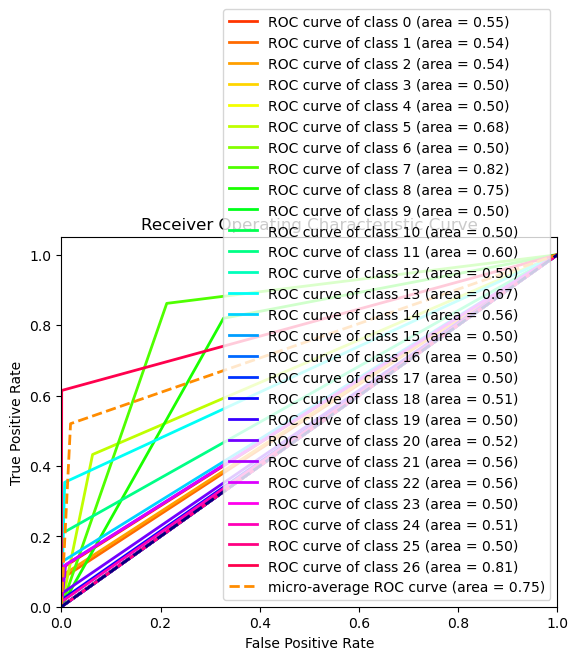

In [11]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb_y_pred = mnb.predict(X_test)
calculate_metrics(y_test, mnb_y_pred,len(encoder.classes_))

Accuracy: 0.5870664206642067
Precision: 0.5648287305739736
Recall: 0.5870664206642067
F1 Score: 0.5516174631264158
Confusion Matrix:
[[  419     2     8     1     0   125     5   120   434     1     1     2
      0    44     2     3     1     0     4     0    29    46    18     0
     40     0     9]
 [    6   168    26     0     0   167     0    31   127     0     0     0
      0     9     1     0     0     0     1     1     3    45     2     0
      3     0     0]
 [   44    50   141    11     0    85     0   118   206     7     5     2
      0    26     0     0     0     0     9     0    12    35     3     0
     12     0     9]
 [   33     0    16    38     0   108     0    73    95    21     5     1
      0    17     2     0     0     0     2     0    22    61     2     0
      2     0     0]
 [    0     0     0     0     0    19     0   170    64     0     0     0
      0     1     1     1     0     0     0     0     0     5     2     1
      0     0     0]
 [   63     7     8   

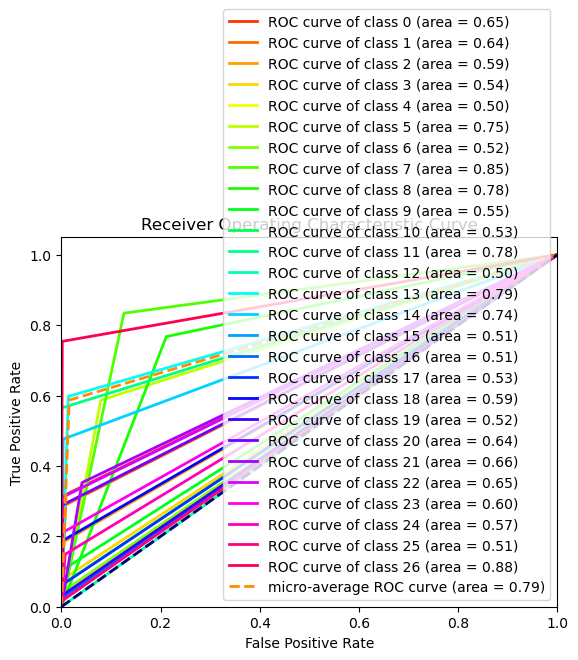

In [12]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)
calculate_metrics(y_test, lr_y_pred,len(encoder.classes_))

Accuracy: 0.5830811808118082
Precision: 0.5764901615914969
Recall: 0.5830811808118082
F1 Score: 0.5380003872979977
Confusion Matrix:
[[  341     2     6     2     0   129     2   138   563     0     0     0
      0    30     0     0     0     0     2     0    24    35    12     0
     21     0     7]
 [    5   162    33     0     0   175     0    33   139     0     0     0
      0     6     1     0     0     0     1     0     3    32     0     0
      0     0     0]
 [   35    37   139     4     0    86     0   132   259     2     3     1
      0    23     0     0     0     0     4     0    10    25     0     0
      7     0     8]
 [   27     0     7    33     0   115     0    93   125    10     1     1
      0    11     2     0     0     0     2     0    20    50     0     0
      1     0     0]
 [    0     0     0     0     0    15     0   177    63     0     0     0
      0     1     1     0     0     0     0     0     1     5     0     0
      0     0     1]
 [   55    10     4   

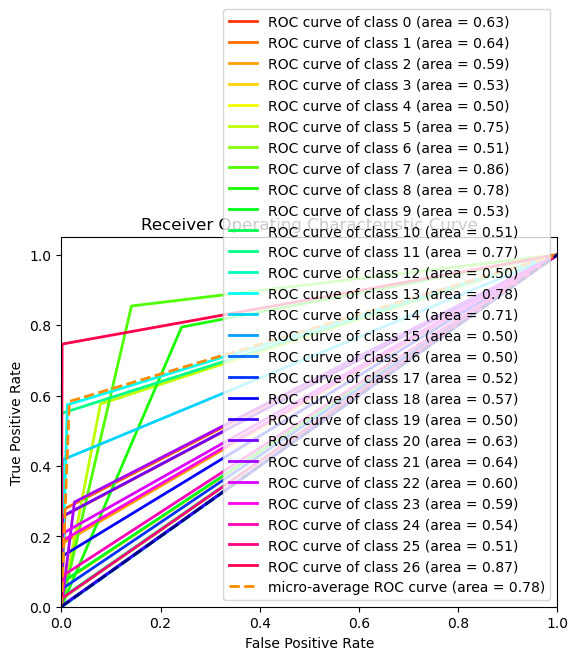

In [13]:
# Support Vector Classifier
from sklearn.svm import SVC
svc = SVC(random_state = 42)
svc.fit(X_train, y_train)
svc_y_pred = svc.predict(X_test)
calculate_metrics(y_test, svc_y_pred,len(encoder.classes_))